# Analysis of "Azerbaijani Laundromat" transaction data

## set up environment

Load the library dependencies

In [1]:
from collections import defaultdict
from datetime import datetime, timedelta
import itertools
import pathlib
import statistics
import typing

from icecream import ic
import networkx as nx
import pandas as pd
import pyvis
import scipy
import watermark

Show a watermark of the OS, hardware, language environment, and dependent library versions.

In [2]:
%load_ext watermark
%watermark
%watermark --iversions

Last updated: 2025-02-19T13:41:59.970703-08:00

Python implementation: CPython
Python version       : 3.13.2
IPython version      : 8.32.0

Compiler    : Clang 16.0.0 (clang-1600.0.26.6)
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

pyvis    : 0.3.2
networkx : 3.4.2
scipy    : 1.15.2
watermark: 2.5.0
pandas   : 2.2.3



Configure `pandas`

In [3]:
pd.set_option("display.max_rows", None)

## load the dataset

Load the OCCRP data for the "Azerbaijani Laundromat" leaked bank transactions <https://github.com/cj2001/senzing_occrp_mapping_demo/blob/main/occrp_17k.csv>

In [4]:
occrp_file: pathlib.Path = pathlib.Path("occrp_17k.csv")
df_orig: pd.DataFrame = pd.read_csv(occrp_file)

In [5]:
df_orig.head()

,payer_name,payer_jurisdiction,payer_account,source_file,amount_orig,id,beneficiary_type,beneficiary_core,amount_orig_currency,beneficiary_name,...,beneficiary_name_norm,payer_core,beneficiary_account,purpose,date,amount_usd,amount_eur,payer_type,payer_name_norm,payer_bank_country
0,AZARBAYCAN METANOL KOMPANI MMC,AZ,33817018409333311204,pdf/LCM ALLIANCE Account statement 30.06.12-31...,535470.00,6049,Company,True,USD,LCM ALLIANCE LLP,...,LCM ALLIANCE LLP,False,EE27 3300 3335 0561 0002,1206295100052180 OCT4121800021 ADVANCE PAYM FO...,2012-06-30,535470,"$431,762.31",Company,AZARBAYCAN METANOL KOMPANI MMC,33
1,LCM ALLIANCE LLP,GB,EE27 3300 3335 0561 0002,pdf/LCM ALLIANCE Account statement 30.06.12-31...,-535000.00,6050,Company,False,USD,MOBILA LLP,...,MOBILA LLP,True,333504500003,1207035026699176 INVOICE.No 6215 DD 25.05.2012,2012-07-03,535000,"$423,688.44",Company,LCM ALLIANCE LLP,EE
2,SKN ELECTRICAL SERVICES LIMITEDACCO,GB,20100374548222,pdf/METASTAR Account statement 30.06.12-31.12....,90535.19,10623,Company,True,USD,METASTAR INVEST LLP,...,METASTAR INVEST LLP,False,EE77 3300 3334 8704 0004,"1207065103089249 /FEE/USD4,81",2012-07-06,90536,"$71,698.53",Company,SKN ELECTRICAL SERVICES LIMITED,20
3,METASTAR INVEST LLP,GB,EE77 3300 3334 8704 0004,pdf/METASTAR Account statement 30.06.12-31.12....,-90520.00,15589,Company,False,USD,INMAXO CAPITAL CORP,...,INMAXO CAPITAL CORP.,True,333455870002,1207095022358525 DOGOVOR ZAYMA,2012-07-09,90520,"$71,686.50",Company,METASTAR INVEST LLP,EE
4,METASTAR INVEST LLP,GB,EE77 3300 3334 8704 0004,pdf/METASTAR Account statement 30.06.12-31.12....,-60.00,10624,Company,False,USD,INMAXO CAPITAL CORP,...,INMAXO CAPITAL CORP.,True,333455870002,1207135024578077 DOGOVOR ZAYMA,2012-07-13,60,$47.52,Company,METASTAR INVEST LLP,EE


In [6]:
df_orig.columns

Index(['payer_name', 'payer_jurisdiction', 'payer_account', 'source_file',
       'amount_orig', 'id', 'beneficiary_type', 'beneficiary_core',
       'amount_orig_currency', 'beneficiary_name', 'beneficiary_jurisdiction',
       'investigation', 'beneficiary_bank_country', 'beneficiary_name_norm',
       'payer_core', 'beneficiary_account', 'purpose', 'date', 'amount_usd',
       'amount_eur', 'payer_type', 'payer_name_norm', 'payer_bank_country'],
      dtype='object')

reduce the dataframe to just the slice needed for this analysis

In [7]:
cols_keep: typing.List[ str ] = [
    "date",
    "amount_orig",
    "payer_name",
    "beneficiary_name",
    "purpose",
    ]

diff: typing.Set[ str ] = set(df_orig.columns) - set(cols_keep)
    
df: pd.DataFrame = df_orig.drop(
    diff,
    axis = 1,
    inplace = False,
).sort_values(by = "date").reindex(columns = cols_keep)

df = df[df["amount_orig"] >= 0]
df.date = pd.to_datetime(df.date)

df.head()

,date,amount_orig,payer_name,beneficiary_name,purpose
0,2012-06-30,535470.00,AZARBAYCAN METANOL KOMPANI MMC,LCM ALLIANCE LLP,1206295100052180 OCT4121800021 ADVANCE PAYM FO...
2,2012-07-06,90535.19,SKN ELECTRICAL SERVICES LIMITEDACCO,METASTAR INVEST LLP,"1207065103089249 /FEE/USD4,81"
5,2012-07-13,189352.15,INMAXO CAPITAL CORP.,METASTAR INVEST LLP,CONTRACT N 001 DD 24.12.2009
6,2012-07-13,225850.00,INMAXO CAPITAL CORP.,METASTAR INVEST LLP,1207135026233261 CONTRACT N 001 DD 24.12.2009
21,2012-07-16,150000.00,MOBILA LLP,METASTAR INVEST LLP,1207165026198353 INVOICE.No 69 DD 13.07.2012


In [8]:
azeri_file: pathlib.Path = pathlib.Path("azeri.csv")
df.to_csv(azeri_file, sep = "\t", encoding = "utf-8")

## descriptive statistics

In [9]:
df.describe(include = "all").loc[[ "count", "mean", "min", "max", "std", "freq", "unique", ]]

,date,amount_orig,payer_name,beneficiary_name,purpose
count,4069,4.069000e+03,4069,4069,4069
mean,2013-06-24 13:09:11.191939072,7.512028e+05,NaN,NaN,NaN
min,2012-06-30 00:00:00,6.600000e-01,NaN,NaN,NaN
max,2014-12-31 00:00:00,2.055997e+07,NaN,NaN,NaN
std,NaN,1.206048e+06,NaN,NaN,NaN
freq,NaN,NaN,530,1708,37
unique,NaN,NaN,437,4,3781


## Network analysis

In [10]:
graph: nx.DiGraph = nx.DiGraph()

net: pyvis.network.Network = pyvis.network.Network(
    notebook = True,
    cdn_resources = "in_line",
    height = "900px", 
    width = "100%",
)

edge_xact: dict = defaultdict(list)

In [11]:
def render_graph (
    graph: nx.DiGraph,
    ) -> pyvis.network.Network:
    """
    Generate a `PyVis` network visualization from the DiGraph
    """
    net: pyvis.network.Network = pyvis.network.Network(
        notebook = True,
        cdn_resources = "in_line",
        height = "900px", 
        width = "100%",
    )

    # calculate the _betweenness centrality_ measures for each country
    for node_id, rank in nx.betweenness_centrality(graph, weight = "weight").items():
        graph.nodes[node_id]["value"] = rank
    
    # load the network and adjust attributes for visualization
    net.from_nx(graph)

    for node in net.nodes:
        node["label"] = node["name"]
        node["title"] = node["name"]
        node["color"] = "#BDC561"

    for edge in net.edges:
        #edge["value"] = edge["width"]
        pass

    return net

construct graphs both in `NetworkX` for analysis and `PyVis` for visualization

In [12]:
node_names: list = []

for index, row in df.iterrows():
    src_label: str = row["payer_name"]
    dst_label: str = row["beneficiary_name"]

    if src_label not in node_names:
        node_names.append(src_label)
        src_id: int = node_names.index(src_label)

        graph.add_node(
            src_id,
            name = src_label,
        )            
    else:
        src_id = node_names.index(src_label)


    if dst_label not in node_names:
        node_names.append(dst_label)
        dst_id: int = node_names.index(dst_label)

        graph.add_node(
            dst_id,
            name = dst_label,
        )
    else:
        dst_id = node_names.index(dst_label)

    graph.add_edge(
        src_id,
        dst_id,
    )

    edge_xact[ (src_id, dst_id) ].append({
        "amount": row["amount_orig"],
        "date": datetime.fromisoformat(str(row["date"])),
    })    

visualize the network of shell corps involved

In [13]:
net: pyvis.network.Network = render_graph(graph)

net.force_atlas_2based()
net.show_buttons(filter_ = ["physics"])

#net.toggle_physics(False)
net.show("occrp.html")

occrp.html


describe the distributions of transaction inter-arrival times and amounts

In [14]:
summary_data: list = []

for edge, dat in edge_xact.items():
    if len(dat) > 1:
        dates: list = sorted([
            xact["date"]
            for xact in dat
        ], reverse = False)

        inter_arrival: list = [
            (pair[1] - pair[0]).days
            for pair in itertools.pairwise(dates)
        ]

        amounts: list = [
            xact["amount"]
            for xact in dat
        ]

        summary_data.append({
            "src_id": edge[0],
            "dst_id": edge[1],
            "median_amount": statistics.median(amounts),
            "total_amount": sum(amounts),
            "inter_arrival": statistics.mean(inter_arrival),
        })

df_summary: pd.DataFrame = pd.DataFrame.from_dict(
    summary_data,
    orient = "columns"
)

df_summary.head()

,src_id,dst_id,median_amount,total_amount,inter_arrival
0,0,1,109510.00,1511916.50,39.750000
1,2,3,10101.00,110063.19,59.500000
2,4,3,189352.15,415231.08,1.500000
3,5,3,300000.00,4729714.00,1.916667
4,6,3,50000.00,12747647.00,3.629310


In [15]:
df_summary.describe()

,src_id,dst_id,median_amount,total_amount,inter_arrival
count,252.000000,252.000000,2.520000e+02,2.520000e+02,252.000000
mean,173.626984,40.829365,3.798608e+05,1.161657e+07,21.156845
std,126.250130,101.164882,5.301957e+05,8.014517e+07,32.745006
min,0.000000,1.000000,1.100000e+02,2.200000e+02,0.000000
25%,64.750000,1.000000,6.717762e+04,3.476025e+05,3.000000
50%,157.500000,1.000000,1.963890e+05,1.408894e+06,8.708333
75%,268.000000,3.000000,4.762237e+05,4.850007e+06,25.569444
max,433.000000,302.000000,4.000000e+06,1.239991e+09,211.000000


now we have some descriptive stats to use for modeling a simulation of these kinds of transactions; let's look into other potential parameters for simulation, based on graph analytics

In [16]:
nx.diameter(graph.to_undirected())

4

In [17]:
nx.harmonic_diameter(graph.to_undirected())

2.4810577123410194

In [18]:
nx.radius(graph.to_undirected())

2

In [19]:
for node_id in nx.center(graph.to_undirected()):
    print(node_id, graph.nodes[node_id])

17 {'name': 'GLOBECOM TRADE L.P', 'value': 0.0, 'size': 10}
66 {'name': 'RIVERLANE LLP', 'value': 0.0, 'size': 10}


In [20]:
for node_id in nx.periphery(graph.to_undirected()):
    print(node_id, graph.nodes[node_id])

0 {'name': 'AZARBAYCAN METANOL KOMPANI MMC', 'value': 0.0, 'size': 10}
2 {'name': 'SKN ELECTRICAL SERVICES LIMITEDACCO', 'value': 0.0, 'size': 10}
4 {'name': 'INMAXO CAPITAL CORP.', 'value': 0.0, 'size': 10}
5 {'name': 'MOBILA LLP', 'value': 0.0, 'size': 10}
6 {'name': 'LOTA SALES LLP', 'value': 0.0, 'size': 10}
8 {'name': 'JETFIELD NETWORKS LIMITED', 'value': 0.0, 'size': 10}
9 {'name': 'MUROVA SYSTEMS LLP', 'value': 0.0, 'size': 10}
10 {'name': 'BONINVEST LLP', 'value': 0.0, 'size': 10}
12 {'name': 'OVERTON SALES LLP', 'value': 0.0, 'size': 10}
13 {'name': 'SOLIDSTAR WORLDWIDE LLP', 'value': 0.0, 'size': 10}
14 {'name': 'SOVER DEVELOPMENT LLP', 'value': 0.0, 'size': 10}
15 {'name': 'BKCHCNBJ', 'value': 0.0, 'size': 10}
16 {'name': 'ADANA INVESTMENT,LTD', 'value': 0.0, 'size': 10}
18 {'name': 'CLIMBFREE SOLUTIONS LIMITED', 'value': 0.0, 'size': 10}
19 {'name': 'LINSTAR SYSTEMS CORP.', 'value': 0.0, 'size': 10}
20 {'name': 'SKN ELECTRICAL SERVICES LIMITED', 'value': 0.0, 'size': 10}
21

In [21]:
len(list(nx.periphery(graph.to_undirected())))

423

In [22]:
len(graph.nodes)

437

In [23]:
nx.eccentricity(graph.to_undirected())

{0: 4,
 1: 3,
 2: 4,
 3: 3,
 4: 4,
 5: 4,
 6: 4,
 7: 3,
 8: 4,
 9: 4,
 10: 4,
 11: 3,
 12: 4,
 13: 4,
 14: 4,
 15: 4,
 16: 4,
 17: 2,
 18: 4,
 19: 4,
 20: 4,
 21: 4,
 22: 4,
 23: 4,
 24: 4,
 25: 4,
 26: 4,
 27: 4,
 28: 4,
 29: 4,
 30: 4,
 31: 4,
 32: 4,
 33: 4,
 34: 4,
 35: 4,
 36: 4,
 37: 4,
 38: 4,
 39: 4,
 40: 4,
 41: 4,
 42: 4,
 43: 4,
 44: 4,
 45: 4,
 46: 4,
 47: 4,
 48: 4,
 49: 4,
 50: 4,
 51: 4,
 52: 4,
 53: 4,
 54: 4,
 55: 4,
 56: 4,
 57: 4,
 58: 4,
 59: 4,
 60: 4,
 61: 4,
 62: 4,
 63: 4,
 64: 4,
 65: 4,
 66: 2,
 67: 4,
 68: 4,
 69: 4,
 70: 4,
 71: 4,
 72: 4,
 73: 4,
 74: 4,
 75: 4,
 76: 4,
 77: 4,
 78: 4,
 79: 4,
 80: 4,
 81: 4,
 82: 4,
 83: 4,
 84: 4,
 85: 4,
 86: 4,
 87: 4,
 88: 4,
 89: 4,
 90: 4,
 91: 4,
 92: 4,
 93: 4,
 94: 4,
 95: 4,
 96: 4,
 97: 4,
 98: 4,
 99: 4,
 100: 4,
 101: 4,
 102: 4,
 103: 4,
 104: 4,
 105: 4,
 106: 4,
 107: 3,
 108: 4,
 109: 4,
 110: 4,
 111: 4,
 112: 4,
 113: 4,
 114: 4,
 115: 4,
 116: 4,
 117: 4,
 118: 4,
 119: 4,
 120: 4,
 121: 4,
 122: 4,
 12

In [24]:
nx.density(graph)

0.0025297587806772616

In [25]:
for clicque in nx.connected_components(graph.to_undirected()):
    print(clicque)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [26]:
for triad, occurrences in nx.triadic_census(graph).items():
    if occurrences > 0:
        print("triad {:>4}: {:7d} occurrences".format(triad, occurrences))

triad  003: 13652536 occurrences
triad  012:  113313 occurrences
triad  102:     425 occurrences
triad 021D:      19 occurrences
triad 021U:   46815 occurrences
triad 021C:      15 occurrences
triad 111D:     411 occurrences
triad 111U:       1 occurrences
triad 030T:       2 occurrences
triad 120D:      33 occurrences


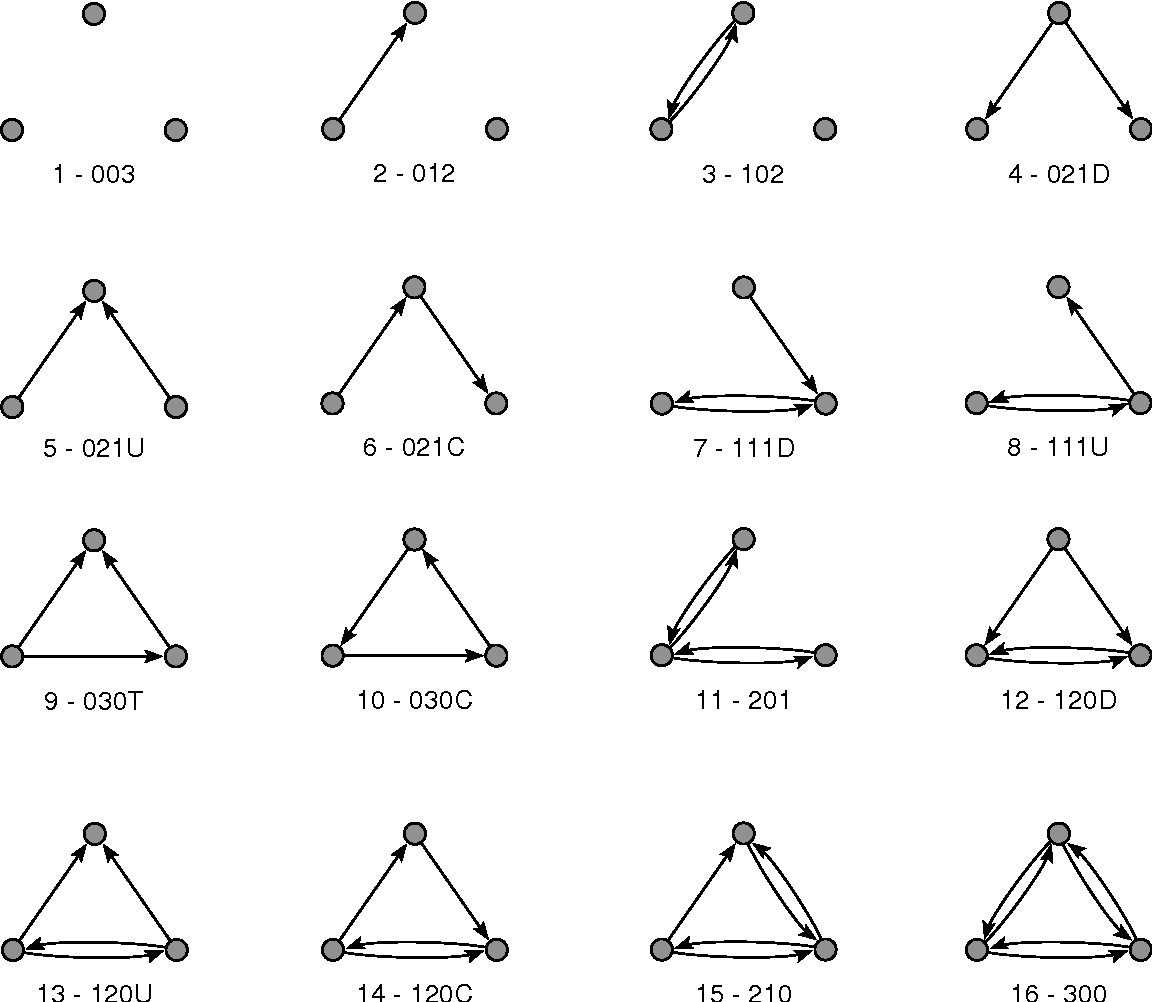

In [27]:
from IPython import display
display.Image("https://figures.semanticscholar.org/6ebe86cdf25f3b58dd98dd9c1c00c3f5c2491734/2-Figure1-1.png")

since we have a relatively small `diameter = 4` let's enumerate the paths

In [28]:
for path in nx.all_pairs_all_shortest_paths(graph):
    print(path)

(0, {0: [[0]], 1: [[0, 1]], 3: [[0, 1, 3]]})
(1, {1: [[1]], 3: [[1, 3]]})
(2, {1: [[2, 3, 1]], 2: [[2]], 3: [[2, 3]]})
(3, {1: [[3, 1]], 3: [[3]]})
(4, {1: [[4, 3, 1]], 3: [[4, 3]], 4: [[4]]})
(5, {1: [[5, 1]], 3: [[5, 3]], 5: [[5]]})
(6, {1: [[6, 1]], 3: [[6, 3]], 6: [[6]]})
(7, {1: [[7, 1]], 3: [[7, 3]], 7: [[7]], 298: [[7, 302, 298]], 302: [[7, 302]]})
(8, {1: [[8, 1]], 3: [[8, 3]], 8: [[8]]})
(9, {1: [[9, 1]], 3: [[9, 3]], 9: [[9]]})
(10, {1: [[10, 1]], 3: [[10, 3]], 10: [[10]]})
(11, {1: [[11, 1]], 3: [[11, 3]], 11: [[11]], 298: [[11, 302, 298]], 302: [[11, 302]]})
(12, {1: [[12, 1]], 3: [[12, 3]], 12: [[12]]})
(13, {1: [[13, 3, 1]], 3: [[13, 3]], 13: [[13]]})
(14, {1: [[14, 1]], 3: [[14, 3]], 14: [[14]]})
(15, {1: [[15, 3, 1]], 3: [[15, 3]], 15: [[15]]})
(16, {1: [[16, 3, 1]], 3: [[16, 3]], 16: [[16]]})
(17, {1: [[17, 1]], 3: [[17, 3]], 17: [[17]], 298: [[17, 298]], 302: [[17, 302]]})
(18, {1: [[18, 3, 1]], 3: [[18, 3]], 18: [[18]]})
(19, {1: [[19, 3, 1]], 3: [[19, 3]], 19: [[19]

In [29]:
nx.flow_hierarchy(graph)

0.9896265560165975

take-aways:

 * this is a relatively sparse graph with diameter = 4
 * 423 nodes out of the 437 total are in the periphery

questions:

 * does the flow hierarchy shows that few edges participate in cycles?
 * does the many `021U` triads indicate "burst in beneficiaries" AML tradecraft pattern?